## Supermarket store branches sales analysis
https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data

At the end of this project, I'll try to predict the Store Sales of Supermarket Store Branches

In [144]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('Stores.csv')

In [4]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [5]:
# There're only numeric variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store ID              896 non-null    int64
 1   Store_Area            896 non-null    int64
 2   Items_Available       896 non-null    int64
 3   Daily_Customer_Count  896 non-null    int64
 4   Store_Sales           896 non-null    int64
dtypes: int64(5)
memory usage: 35.1 KB


In [6]:
# There is no NaN
df.isna().sum()

Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64

In [7]:
df.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804
std,258.797218,250.237011,299.872053,265.389281,17190.741895
min,1.000000,775.000000,932.000000,10.000000,14920.000000
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000


In [8]:
# There's one branch that only has 10 daily customers. This value seems is to be too low in comparison with the mean,
# so it might be an outlier
df.Daily_Customer_Count.nsmallest(5)

39      10
151     70
876    100
230    120
146    130
Name: Daily_Customer_Count, dtype: int64

In [9]:
# Getting the z-score of that value. 
# It'll be considered an outlier if the zscore is greater than |3|
stats.zscore(df.Daily_Customer_Count)[39]

-2.926960872097397

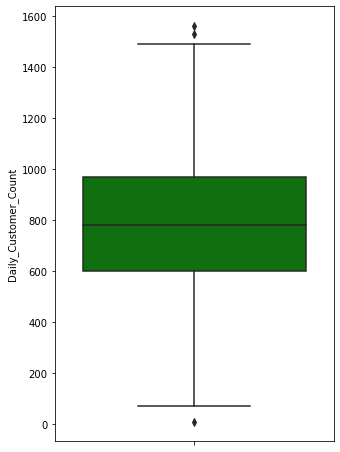

In [10]:
# Checking wheter the 10 daily consumers is really too low or an accetable value.
# It's not very far from the last percentile, so I'll keep it.
plt.figure(figsize=(5,8))
sns.boxplot(data = df , y = 'Daily_Customer_Count', color = 'green');

In [11]:
# Visualizing the other columns in the line where the daily costumer is 10 to check if they seem ok, only to confirm.
# All the other lines show regular values.
df.loc[39]


Store ID                   40
Store_Area               1270
Items_Available          1516
Daily_Customer_Count       10
Store_Sales             45480
Name: 39, dtype: int64

In [12]:
# There is no duplicated values.
df.duplicated().sum()

0

In [13]:
df.columns

Index(['Store ID ', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

In [14]:
# Taking the black space out of the first column name ('Store ID').
df.columns = df.columns.str.replace(df.columns[0], df.columns[0][:-1])

In [15]:
df.columns

Index(['Store ID', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

In [16]:
# Setting Store ID as index
df.set_index(['Store ID'])

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store ID,,,,
1,1659,1961,530,66490
2,1461,1752,210,39820
3,1340,1609,720,54010
4,1451,1748,620,53730
5,1770,2111,450,46620
...,...,...,...,...
892,1582,1910,1080,66390
893,1387,1663,850,82080
894,1200,1436,1060,76440


# Variable Analysis:
- Compare the variables with the target variable 'Store_Sales'


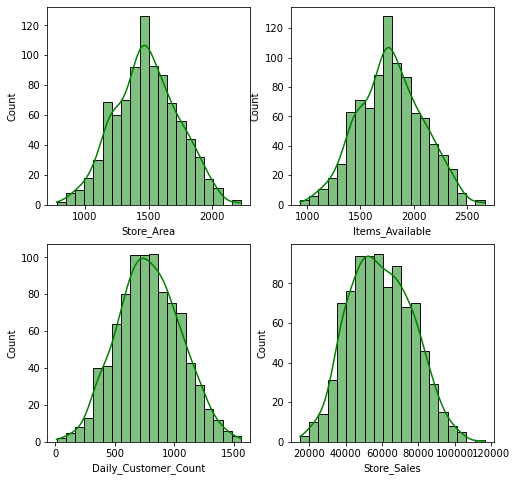

In [17]:
# Plotting a histogram to all the variables of the dataset
# They alll have a Gaussian Distribution
plt.figure(figsize = (8,8))

for i in range(1, len(df.columns)):
    plt.subplot(2, 2, i)
    sns.histplot(data = df, x = df.columns[i], bins = 20, color = 'green', kde = True)

In [18]:
# Variables Correlation
corr_df = df[df.columns].corr()

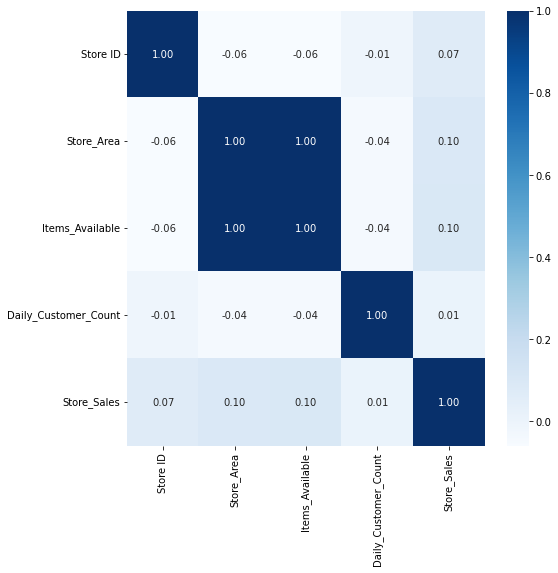

In [19]:
# Heatmap
# It's possible to see that Store_Area and Item_avaliable is totally positive related(1.0). 
# Even tough it's suspicious to have such a positive relation, it makes sense, since the more itens a supermarket has,
# the more area is needed
# The others variables are not much related.
plt.figure(figsize=(8,8))

sns.heatmap(data = corr_df, cmap = 'Blues', annot = True, fmt = '.2f')

*Decision*: We might take a decision here to only apply Feature Engineering in variables which the correlation is >=  0.10
('Daily_Customer_Count' won't be used to train the algorithm)

In [20]:
df.columns

Index(['Store ID', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

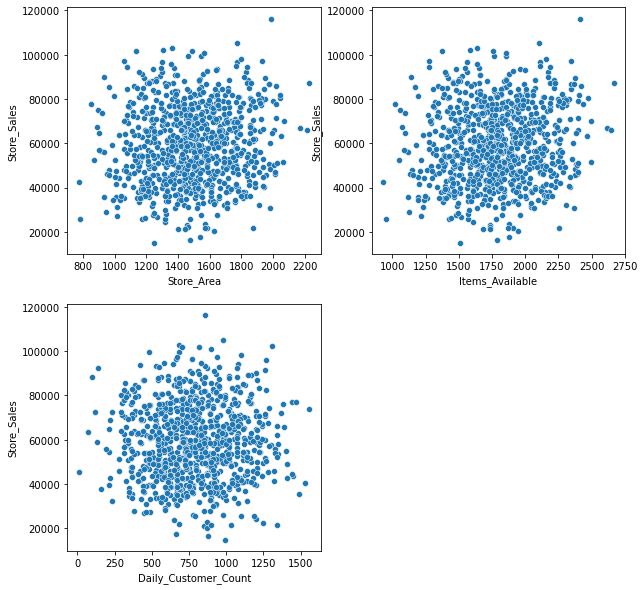

In [21]:
# Comparing the variables with the the Store Sales using a scatterplot
plt.figure(figsize=(10,10))

for i in range(1, len(df.columns)-1):
    plt.subplot(2,2, i)
    sns.scatterplot(data = df, x = df.columns[i], y = 'Store_Sales');

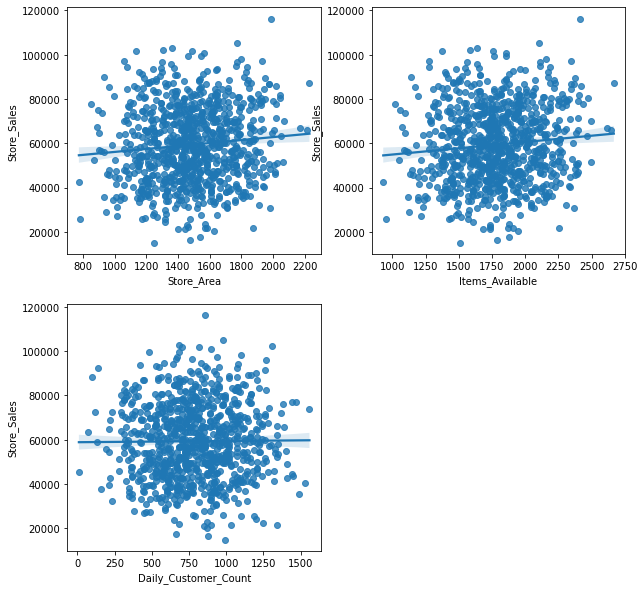

In [22]:
# Regression plot
# It's able to see more clearly the relation between the variables and the Store Sales
plt.figure(figsize=(10,10))

for i in range(1,len(df.columns)-1):
    plt.subplot(2,2,i)
    sns.regplot(data = df, x = df.columns[i], y='Store_Sales')

> Conclusion: The 'Store_Area' and 'Items_Available' area have a slight positive relation with the target variable 'Store_Sales'

**Feature Engineering**

I'm going to create separate the variable 'Store_Area' and 'Items_Available' into bins and put into new variables

In [23]:
df_eng = df.copy()

In [24]:
df_eng.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [25]:
df_eng.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804
std,258.797218,250.237011,299.872053,265.389281,17190.741895
min,1.000000,775.000000,932.000000,10.000000,14920.000000
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000


In [26]:
# The variable 'Store_Area' and 'Items_Available' will be put in bins
bin1 = [0, 1250, 1750, 2250]
label_bin1 = ['<1250m²', '1250-1749m²', '1750-2250m²']
bin2 = [0, 1300, 1800, 2300, 2800]
label_bin2 = ['<1300','1300-1799','1800-2299', '2300-2800']

In [27]:
df_eng['Store_Area_bins'] = pd.cut(df_eng['Store_Area'],
                                    bins = bin1,
                                    labels=label_bin1,
                                    )

In [28]:
df_eng.Store_Area_bins.value_counts()

1250-1749m²    572
<1250m²        178
1750-2250m²    146
Name: Store_Area_bins, dtype: int64

In [29]:
df_eng.sample(10)

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Store_Area_bins
376,377,1496,1774,810,75490,1250-1749m²
420,421,1161,1404,430,58380,<1250m²
640,641,1440,1749,490,75530,1250-1749m²
57,58,1470,1763,1080,83660,1250-1749m²
612,613,1677,2014,660,60800,1250-1749m²
55,56,1417,1701,740,48670,1250-1749m²
570,571,1199,1461,1070,54370,<1250m²
331,332,1633,1968,330,81470,1250-1749m²
717,718,1582,1894,1100,41800,1250-1749m²
456,457,1455,1757,650,67520,1250-1749m²


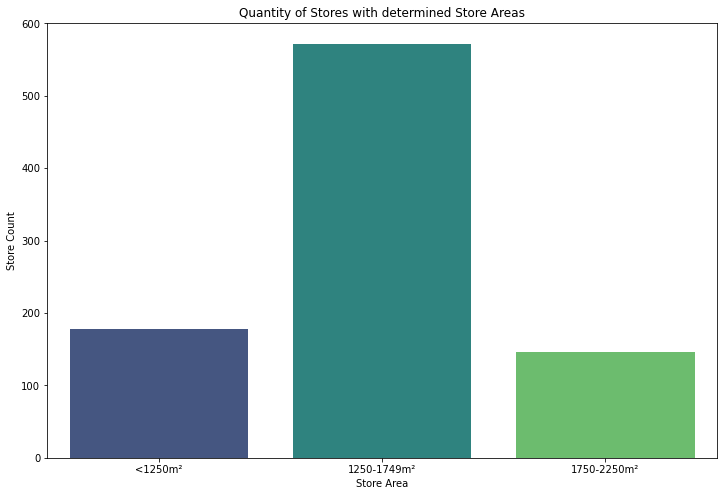

In [30]:
plt.figure(figsize =(12,8))
sns.countplot(x = df_eng['Store_Area_bins'], orient = 'v', palette = 'viridis')
plt.title('Quantity of Stores with determined Store Areas')
plt.xlabel('Store Area')
plt.ylabel('Store Count')
plt.show()

In [31]:
df_eng['Items_Available_bins'] = pd.cut(df_eng['Items_Available'],
                                                bins = bin2,
                                                labels = label_bin2)

In [32]:
df_eng.Items_Available_bins.value_counts()

1300-1799    437
1800-2299    372
<1300         47
2300-2800     40
Name: Items_Available_bins, dtype: int64

In [33]:
df_eng.sample(8)

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Store_Area_bins,Items_Available_bins
375,376,1391,1683,890,68390,1250-1749m²,1300-1799
658,659,1348,1623,1010,72940,1250-1749m²,1300-1799
839,840,1172,1413,480,53940,<1250m²,1300-1799
757,758,1389,1683,680,56880,1250-1749m²,1300-1799
232,233,1245,1499,570,45650,<1250m²,1300-1799
583,584,1408,1708,220,42810,1250-1749m²,1300-1799
836,837,1211,1462,670,38530,<1250m²,1300-1799
443,444,1307,1570,1080,41710,1250-1749m²,1300-1799


In [34]:
# They've become categorical
new_columns = ['Items_Available_bins', 'Store_Area_bins']

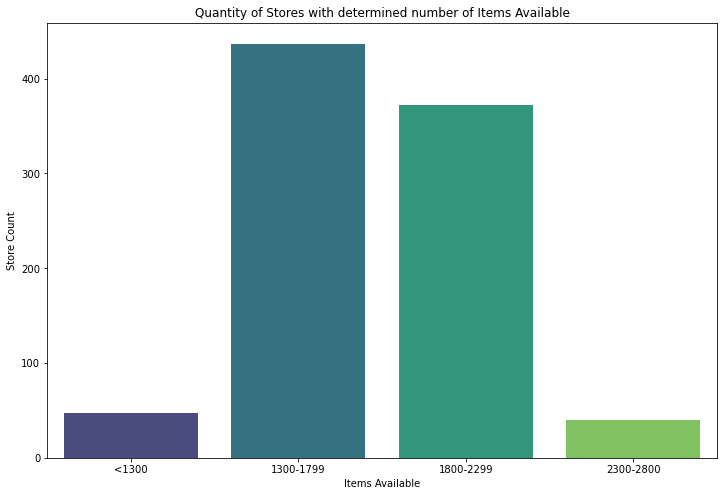

In [35]:
plt.figure(figsize =(12,8))
sns.countplot(x = df_eng['Items_Available_bins'], orient = 'v', palette = 'viridis')
plt.title('Quantity of Stores with determined number of Items Available')
plt.xlabel('Items Available')
plt.ylabel('Store Count')
plt.show()

Most of the stores have between 1300 to 2299 Items Available

### Visualizing the Store sales by the Store Area

In [36]:
df_report1 = df_eng.groupby(['Store_Area_bins']).agg({'Store_Sales':['mean']}).reset_index()
df_report1

,Store_Area_bins,Store_Sales
,,mean
0,<1250m²,56983.820225
1,1250-1749m²,59247.657343
2,1750-2250m²,62643.767123


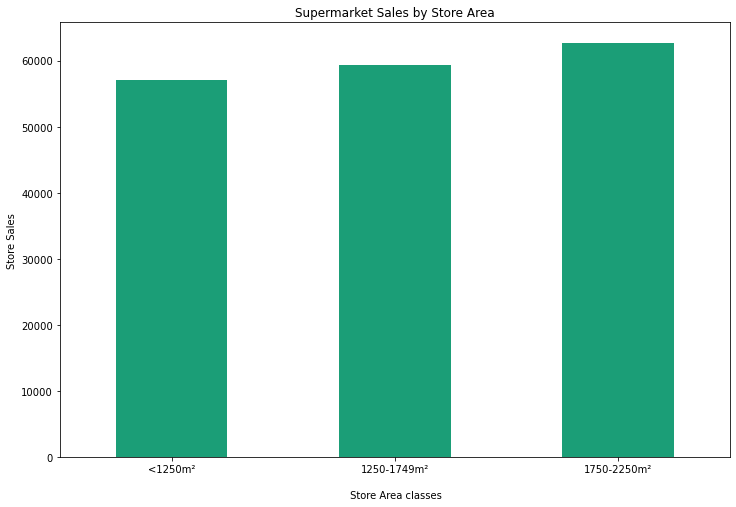

In [37]:
df_report1.set_index('Store_Area_bins').plot(kind = 'bar',
                                             title = 'Supermarket Sales by Store Area',
                                             xlabel = '\n Store Area classes',
                                             ylabel = 'Store Sales',
                                             figsize = (12,8),
                                             colormap = 'Dark2',
                                             legend = '')
plt.xticks(rotation = 0)
plt.show()

>Conclusion: It's possible to saythat the Store Area has a slight positive relation in the Store Sales 

### Visualizing the Store Sales by the Items Available

In [38]:
df_report2 = df_eng.groupby(['Items_Available_bins']).agg({'Store_Sales':['mean']}).reset_index()
df_report2

,Items_Available_bins,Store_Sales
,,mean
0,<1300,54998.936170
1,1300-1799,58641.556064
2,1800-2299,59944.784946
3,2300-2800,66700.000000


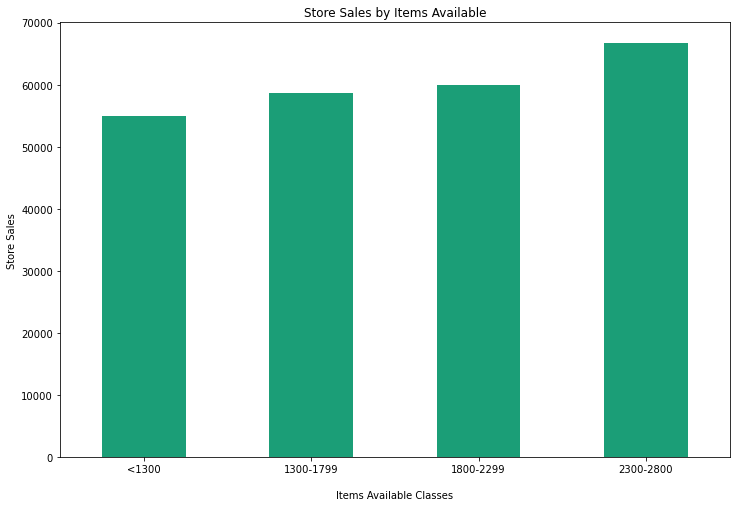

In [39]:
df_report2.set_index('Items_Available_bins').plot(kind = 'bar',
                                                  title = 'Store Sales by Items Available',
                                                  xlabel = '\nItems Available Classes',
                                                  ylabel = 'Store Sales',
                                                  figsize = (12,8),
                                                  colormap = 'Dark2',
                                                  legend = '')
plt.xticks(rotation = 0)
plt.show()

>Conclusion: It's possible to say that the 'Items Available' has a slight positive relation in the Store Sales 

**Comparing the quantity of itens available with the Store Area**

### Visualizing the Store Area by Items Available

In [40]:
df_report3 = df_eng.groupby(['Items_Available_bins']).agg({'Store_Area':['mean']}).reset_index()
df_report3

,Items_Available_bins,Store_Area
,,mean
0,<1300,989.148936
1,1300-1799,1334.324943
2,1800-2299,1670.741935
3,2300-2800,1995.525000


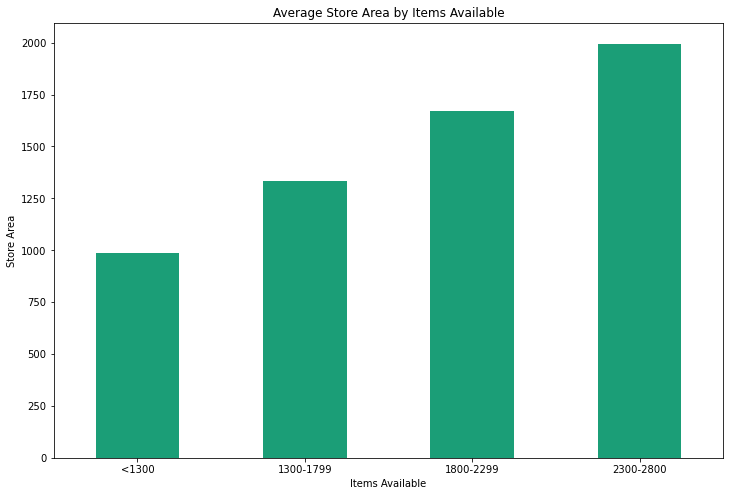

In [41]:
df_report3.set_index('Items_Available_bins').plot(kind = 'bar',
                                                  title = 'Average Store Area by Items Available',
                                                  xlabel = 'Items Available',
                                                  ylabel = 'Store Area',
                                                  colormap = 'Dark2',
                                                  figsize = (12,8),
                                                  legend = '')
plt.xticks(rotation = 0)
plt.show()

> Conclusion: Store Area has a positive correlation with Items Available

### Comparing the Store Area with the number of Daily Customer

In [42]:
df_report4 = df_eng.groupby(['Store_Area_bins']).agg({'Daily_Customer_Count':'mean'}).reset_index()
df_report4

,Store_Area_bins,Daily_Customer_Count
0,<1250m²,816.292135
1,1250-1749m²,776.520979
2,1750-2250m²,788.356164


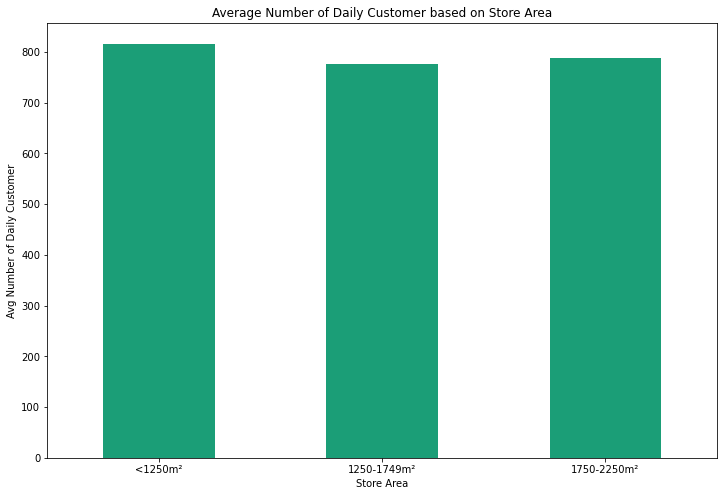

In [43]:
df_report4.set_index('Store_Area_bins').plot(kind = 'bar',
                                             title = 'Average Number of Daily Customer based on Store Area',
                                             xlabel = 'Store Area',
                                             ylabel = 'Avg Number of Daily Customer',
                                             figsize = (12,8),
                                             colormap = 'Dark2',
                                             legend = '')
plt.xticks(rotation = 0)
plt.show()

*Conclusion:* The Store area doesn't seem to have relation with the number of Daily Customer

In [44]:
df_eng.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Store_Area_bins,Items_Available_bins
0,1,1659,1961,530,66490,1250-1749m²,1800-2299
1,2,1461,1752,210,39820,1250-1749m²,1300-1799
2,3,1340,1609,720,54010,1250-1749m²,1300-1799
3,4,1451,1748,620,53730,1250-1749m²,1300-1799
4,5,1770,2111,450,46620,1750-2250m²,1800-2299


## Pre-Processing

In [45]:
# Reorganizing the dataset
df_eng.insert(3,'Items_Available_bins', df_eng.pop('Items_Available_bins'))
df_eng.insert(2, 'Store_Area_bins', df_eng.pop('Store_Area_bins'))

In [46]:
df_eng.head()

,Store ID,Store_Area,Store_Area_bins,Items_Available,Items_Available_bins,Daily_Customer_Count,Store_Sales
0,1,1659,1250-1749m²,1961,1800-2299,530,66490
1,2,1461,1250-1749m²,1752,1300-1799,210,39820
2,3,1340,1250-1749m²,1609,1300-1799,720,54010
3,4,1451,1250-1749m²,1748,1300-1799,620,53730
4,5,1770,1750-2250m²,2111,1800-2299,450,46620


We need to choose which columns we are going to use to train the algorithm. We are going to try with both original columns(df_num)(using LinearRegression()) and the bins columns(df_bins) created to see which one will present the best performace.

In [47]:
df_bins = df_eng.copy()

In [48]:
df_bins.columns

Index(['Store ID', 'Store_Area', 'Store_Area_bins', 'Items_Available',
       'Items_Available_bins', 'Daily_Customer_Count', 'Store_Sales'],
      dtype='object')

In [49]:
# The column 'Daily_Customer_Count' will be taken out as well because of its correlation with the target variable
df_bins.drop(['Store_Area', 'Items_Available', 'Daily_Customer_Count'], axis = 1, inplace = True)

In [50]:
df_bins.head()

,Store ID,Store_Area_bins,Items_Available_bins,Store_Sales
0,1,1250-1749m²,1800-2299,66490
1,2,1250-1749m²,1300-1799,39820
2,3,1250-1749m²,1300-1799,54010
3,4,1250-1749m²,1300-1799,53730
4,5,1750-2250m²,1800-2299,46620


In [51]:
df_bins = df_bins.set_index('Store ID')

In [77]:
df_num = df_eng.copy()

In [78]:
df_num.drop(['Store_Area_bins','Items_Available_bins', 'Daily_Customer_Count'], axis = 1, inplace = True)

In [79]:
df_num.head()

,Store ID,Store_Area,Items_Available,Store_Sales
0,1,1659,1961,66490
1,2,1461,1752,39820
2,3,1340,1609,54010
3,4,1451,1748,53730
4,5,1770,2111,46620


In [80]:
df_num = df_num.set_index('Store ID')

## Label Encoding

> df_bins

We're going to use Label Encoding because there is no many excluded categories in the variables we will work, and also because we out variables are ordinal categories

In [56]:
df_bins.Store_Area_bins.value_counts()

1250-1749m²    572
<1250m²        178
1750-2250m²    146
Name: Store_Area_bins, dtype: int64

In [57]:
df_bins.Items_Available_bins.value_counts()

1300-1799    437
1800-2299    372
<1300         47
2300-2800     40
Name: Items_Available_bins, dtype: int64

In [58]:
# # Remember to only fit the train data
le = LabelEncoder()

In [59]:
le.fit(df_bins.Store_Area_bins)

LabelEncoder()

In [60]:
list(le.classes_)

['1250-1749m²', '1750-2250m²', '<1250m²']

In [61]:
df_bins.Store_Area_bins = le.transform(df_bins.Store_Area_bins)

In [62]:
df_bins.head()

,Store_Area_bins,Items_Available_bins,Store_Sales
Store ID,,,
1,0,1800-2299,66490
2,0,1300-1799,39820
3,0,1300-1799,54010
4,0,1300-1799,53730
5,1,1800-2299,46620


In [63]:
le.fit(df_bins.Items_Available_bins)

LabelEncoder()

In [64]:
list(le.classes_)

['1300-1799', '1800-2299', '2300-2800', '<1300']

In [65]:
df_bins.Items_Available_bins = le.transform(df_bins.Items_Available_bins)

In [66]:
df_bins.head()

,Store_Area_bins,Items_Available_bins,Store_Sales
Store ID,,,
1,0,1,66490
2,0,0,39820
3,0,0,54010
4,0,0,53730
5,1,1,46620


## Pre Processing

We are going to Standardize the data since the variable are in a Gaussian Distribution

# Standardize

In [82]:
df_num

,Store_Area,Items_Available,Store_Sales
Store ID,,,
1,1659,1961,66490
2,1461,1752,39820
3,1340,1609,54010
4,1451,1748,53730
5,1770,2111,46620
...,...,...,...
892,1582,1910,66390
893,1387,1663,82080
894,1200,1436,76440


In [157]:
# Separing the input and output variables
array = df_num.values

X = array[:, 0:2]
Y = array[:, 2]

len(Y)

896

In [151]:
# Standardizing the input variables
standard = StandardScaler()
standardX = standard.fit_transform(X)
standardX

array([[ 0.69409138,  0.59713547],
       [-0.09760039, -0.10021771],
       [-0.58141204, -0.57735409],
       ...,
       [-1.1411941 , -1.15458901],
       [-0.74534821, -0.74084837],
       [-1.24515363, -1.17794534]])

In [160]:
# Visualizing the dataset Standardized
new_df = df_num.copy()
for i in ['Store_Area', 'Items_Available']:
    new_df[i] = standard.fit_transform(df_num[i].values.reshape(len(df_num), 1))
new_df.head()


,Store_Area,Items_Available,Store_Sales
Store ID,,,
1,0.694091,0.597135,66490
2,-0.097600,-0.100218,39820
3,-0.581412,-0.577354,54010
4,-0.137585,-0.113564,53730
5,1.137919,1.097628,46620


# Linear Regression

In [178]:
Y_test.shape

(269,)

- Using Train/Test data (70/30)

In [180]:
# Separating the data into train and test data (70/30)
X_train, X_test, Y_train, Y_test = train_test_split(new_df[['Store_Area', 'Items_Available']].values, new_df[['Store_Sales']].values, test_size = 0.30)

# Creating de model
linear = LinearRegression()

# Training the model
linear.fit(X_train, Y_train)

# Model score
print(linear.score(X_train, Y_train))
print('Accuracy: %.2f%%' % (linear.score(X_test, Y_test) * 100))


Y_predict = linear.predict(X_test)
# The coefficients
print('Coefficient: \n', linear.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_predict))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_predict))

0.007666576410991333
Accuracy: -0.96%
Coefficient: 
 [[ 4214.6225564  -2702.15978433]]
Mean squared error: 296343694.35
Coefficient of determination: -0.01


In [179]:
# Separating the data into train and test data (70/30)
X_train, X_test, Y_train, Y_test = train_test_split(standardX, Y, test_size = 0.30)

# Creating de model
linear = LinearRegression()

# Training the model
linear.fit(X_train, Y_train)

# Model score
print(linear.score(X_train, Y_train))
print('Accuracy: %.2f%%' % (linear.score(X_test, Y_test) * 100))


Y_predict = linear.predict(X_test)
# The coefficients
print('Coefficient: \n', linear.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_predict))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_predict))


0.014194046458547604
Accuracy: -0.50%
Coefficient: 
 [-22322.32021724  24073.3979303 ]
Mean squared error: 273596124.70
Coefficient of determination: -0.00


In [135]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits= 7, shuffle = True, random_state= 7)

modelo = LinearRegression()
result2 = cross_val_score(modelo, standardX , Y, cv = kfold)

print('Accuracy: %.3f%%' % (result2.mean() * 100))

Accuracy: 0.263%


In [131]:
standardX

array([[ 0.69409138,  0.59713547],
       [-0.09760039, -0.10021771],
       [-0.58141204, -0.57735409],
       ...,
       [-1.1411941 , -1.15458901],
       [-0.74534821, -0.74084837],
       [-1.24515363, -1.17794534]])

In [70]:
df_bins.Store_Sales = standard.fit_transform(df_bins.Store_Sales.values.reshape(len(df_bins), 1))

In [71]:
df_bins.head()

,Store_Area_bins,Items_Available_bins,Store_Sales
Store ID,,,
1,0,1,0.415496
2,0,0,-1.136787
3,0,0,-0.310882
4,0,0,-0.327179
5,1,1,-0.741004


## Standardize

> df_num

We're going to Standardize the scalar variables because they have Gaussion Distribution, as it shows is the first lines of this Project

> WE WILL ONLY FIT THE TRAIN DATA. THIS IS TEMPORARY

In [72]:
df_num.head()

,Store_Area,Items_Available,Store_Sales
Store ID,,,
1,1659,1961,66490
2,1461,1752,39820
3,1340,1609,54010
4,1451,1748,53730
5,1770,2111,46620


In [73]:
standard = StandardScaler()
for i in df_num.columns:
    df_num[i] = standard.fit_transform(df_num[i].values.reshape(len(df_num), 1))

In [74]:
df_num.head()

,Store_Area,Items_Available,Store_Sales
Store ID,,,
1,0.694091,0.597135,0.415496
2,-0.097600,-0.100218,-1.136787
3,-0.581412,-0.577354,-0.310882
4,-0.137585,-0.113564,-0.327179
5,1.137919,1.097628,-0.741004
